# Corpus Generator## Introduction
As it can be seen in the media\dataset\base_images there are several base images that roughly corresponds to the Harry Potter Wand Movements. While a DCGAN will be used for better detection, these must be augmented in order to have something to start working with. Thus,Akbumentationsg comes into play.

In [1]:
#!pip install albumentations glob2 Pillow scikit-learn tqdm  opencv-python-headless

In [2]:
from IPython.display import Image, display
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tnrange, tqdm_notebook
import os
from PIL import Image
from matplotlib.pyplot import imread as imshow

from sklearn.model_selection import train_test_split
from tqdm import tqdm, tnrange, tqdm_notebook
import albumentations as A
from albumentations.augmentations import transforms
from albumentations.core.composition import OneOf, Compose
import cv2
import numpy as np
import pandas as pd

LABEL_FILE_NAME = "./media/base_images/labels.csv"
NUMBER_OF_SAMPLES_PER_SYMBOL = 128  # How many samples to try per symbol for debugging
SHAPE = (224, 224)  # w x h in pixels for the images

In [3]:
list_of_files = glob("media/base_images/*.png")

In [4]:
base_images = {
    a[1].split(".")[0]: os.path.join(a[0], a[1])
    for a in [os.path.split(a_file) for a_file in list_of_files]
}

In [5]:
def load_image(a_path):
    return np.asarray(Image.open(a_path).convert("RGB").resize(SHAPE, Image.ANTIALIAS))


def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(4, 4)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])
        fig.tight_layout()

# Augmentation
Let's see how can we get this into work with a single image and then extend it to the rest of the corpus.

/tmp/ipykernel_825/2115910352.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return np.asarray(Image.open(a_path).convert('RGB').resize(SHAPE, Image.ANTIALIAS))


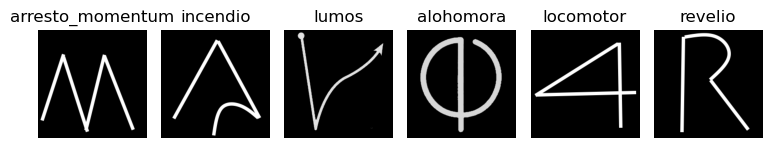

In [6]:
grid_display(
    [load_image(base_images[label]) for label in list(base_images.keys())],
    list(base_images.keys()),
    no_of_columns=8,
    figsize=(10, 10),
)

In [7]:
# Define the augmentation pipeline in Albumentations
transform = A.Compose(
    [
        A.RandomCrop(
            width=SHAPE[0], height=SHAPE[1]
        ),  # Adjust the dimensions accordingly
        # Apply Gaussian blur with 50% probability
        A.OneOf(
            [
                A.GaussianBlur(
                    blur_limit=(3, 7)
                ),  # blur_limit in Albumentations refers to kernel size
            ],
            p=0.5,
        ),
        # Add Gaussian noise
        A.GaussNoise(var_limit=(0, 0.05 * 255)),
        # Multiply brightness of images, with channel-wise variance
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
        # Affine transformations: scale, translate, rotate, shear
        A.Affine(
            scale=(0.97, 1.03),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-10, 10),  # You can adjust the rotation limit as needed
            shear=(-5, 5),
        ),
        # Apply one of several transformations: dropout, elastic, or piecewise affine
        A.OneOf(
            [
                A.CoarseDropout(
                    max_holes=8,
                    max_height=8,
                    max_width=8,
                    min_holes=1,
                    min_height=4,
                    min_width=4,
                    fill_value=0,
                    p=0.5,
                ),  # Dropout
                A.ElasticTransform(alpha=1.5, sigma=2),  # Elastic transformation
                A.PiecewiseAffine(scale=(0.05, 0.1)),  # Piecewise affine transformation
            ],
            p=0.5,
        ),
    ],
    p=1.0,
)  # Apply augmentations in random order


# Example: applying the augmentation to a batch of images
def augment_image(image):
    augmented = transform(image=image)
    return augmented["image"]


images_aug = [
    augment_image(cv2.imread(base_images["lumos"]))
    for _ in range(NUMBER_OF_SAMPLES_PER_SYMBOL)
]

/opt/conda/lib/python3.10/site-packages/albumentations/core/validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


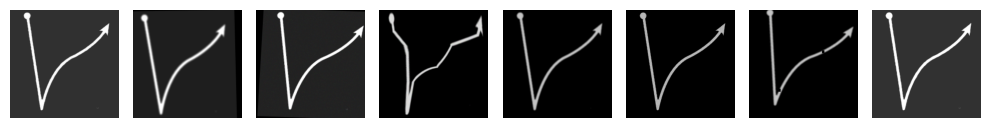

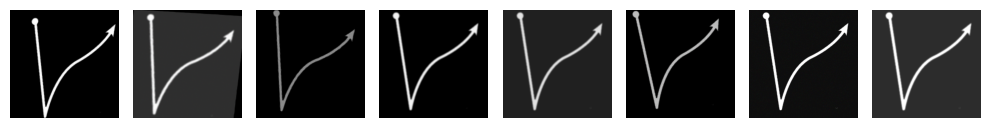

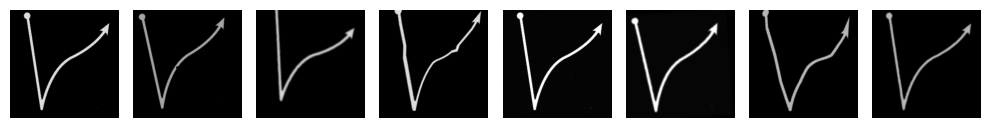

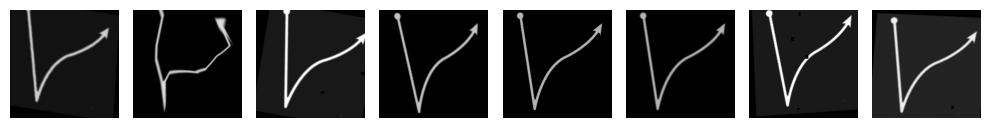

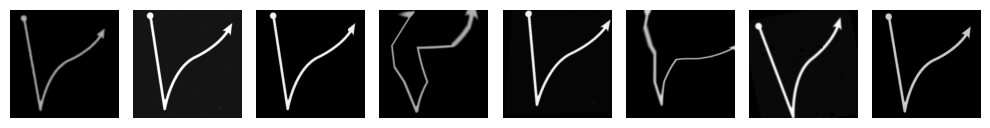

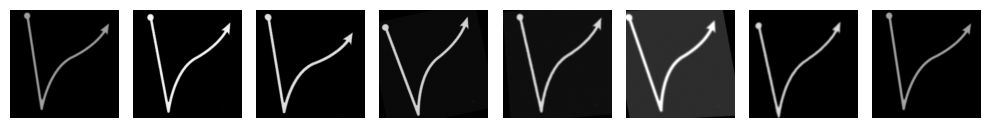

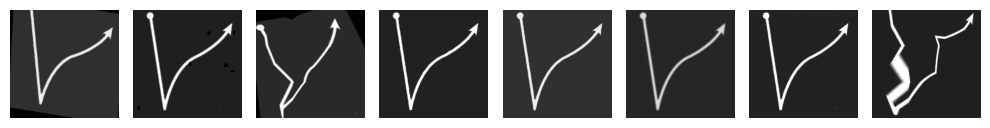

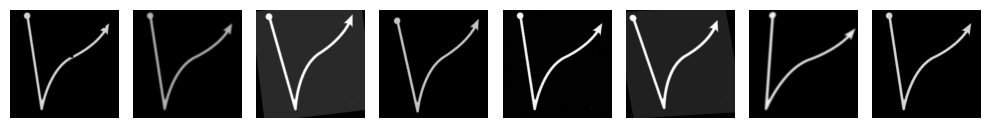

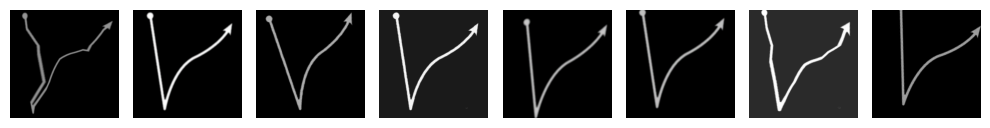

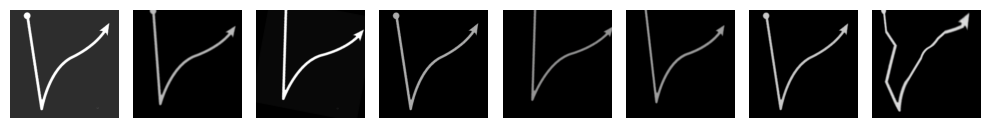

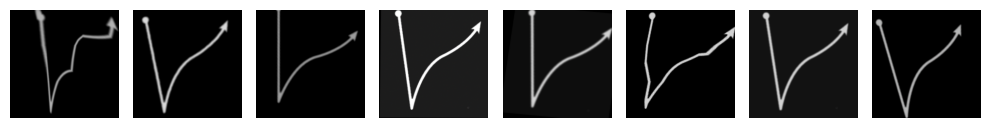

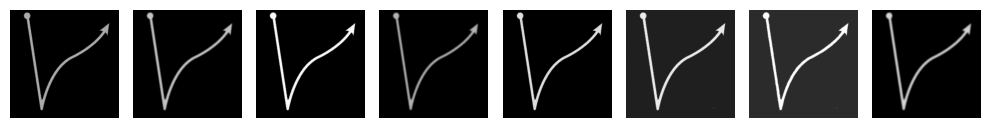

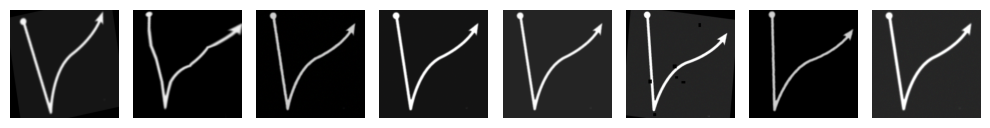

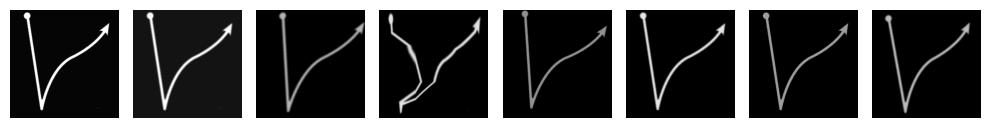

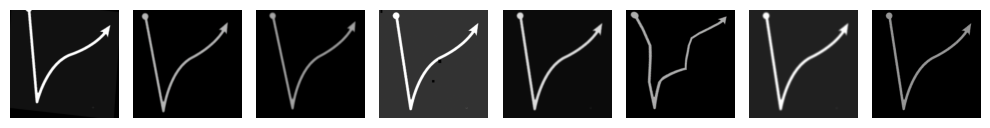

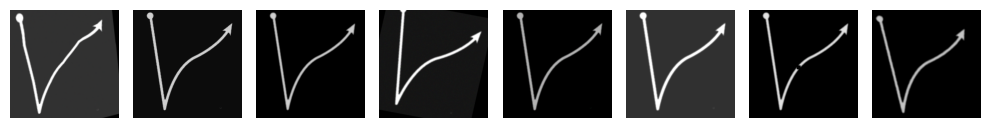

In [8]:
grid_display(images_aug, no_of_columns=8, figsize=(10, 10))

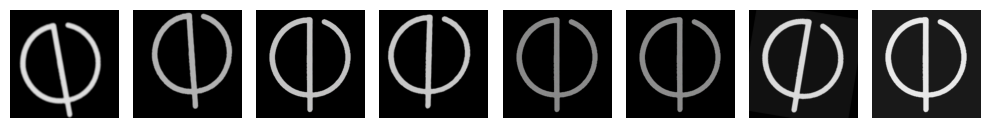

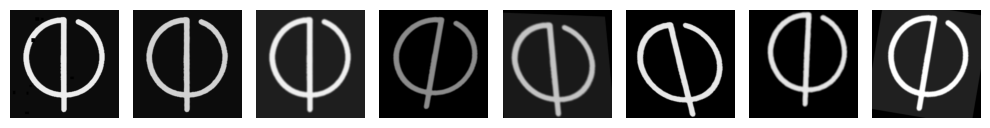

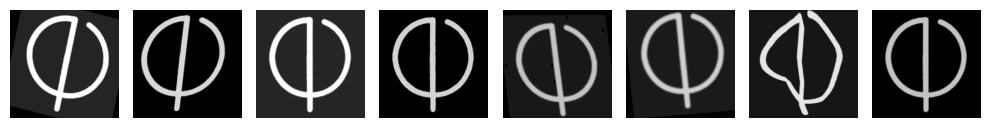

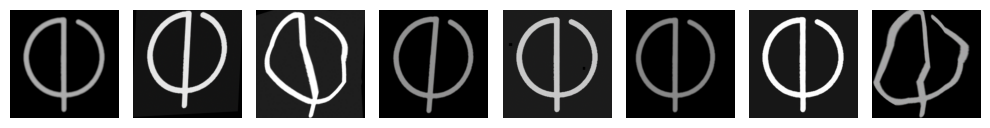

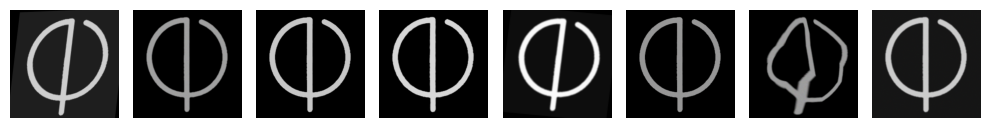

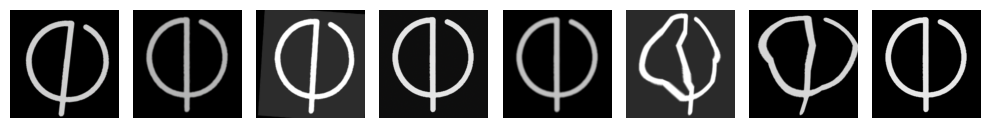

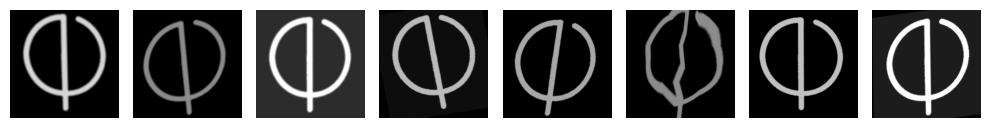

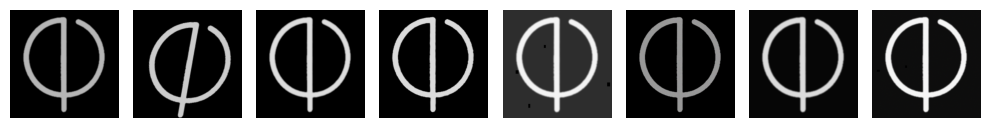

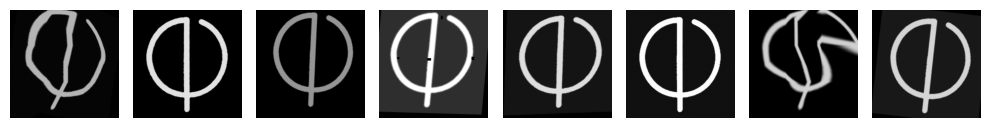

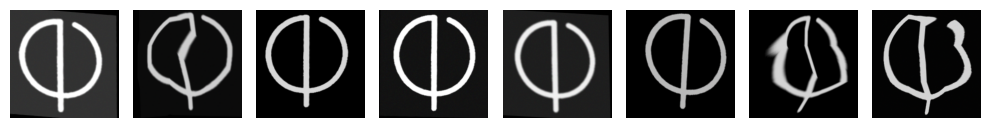

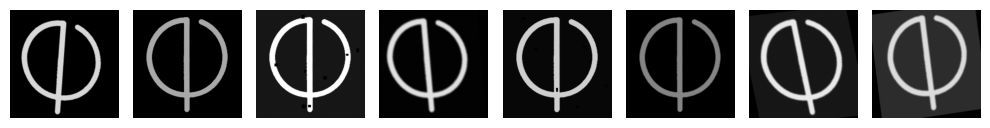

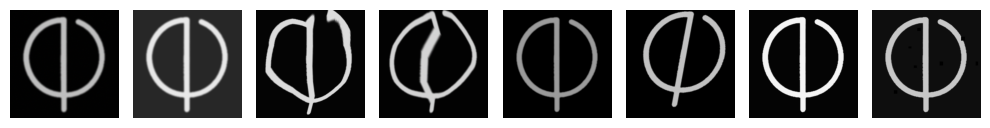

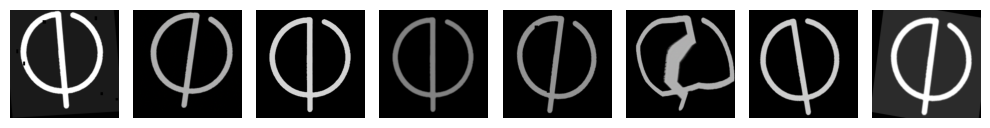

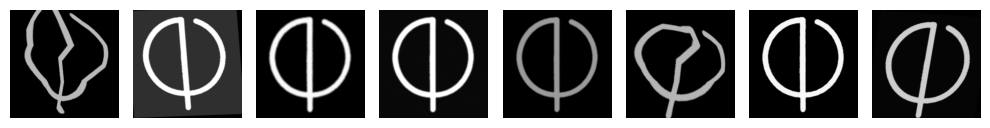

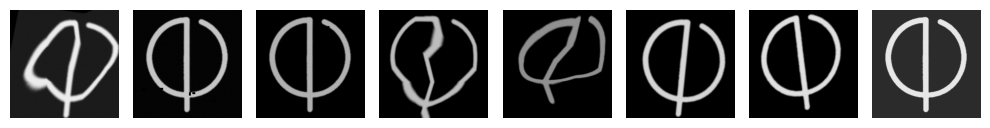

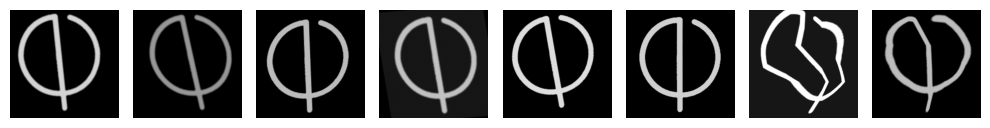

In [9]:
grid_display(
    [
        augment_image(cv2.imread(base_images["alohomora"]))
        for _ in range(NUMBER_OF_SAMPLES_PER_SYMBOL)
    ],
    no_of_columns=8,
    figsize=(10, 10),
)

In [ ]:
for a_symbol in base_images.keys():
    print("Augmenting {}...".format(a_symbol))
    images_aug = [
        augment_image(cv2.imread(base_images[a_symbol])) for _ in tnrange(1500)
    ]
    train, test = train_test_split(images_aug, test_size=0.2)
    for element in tqdm_notebook(zip(["train", "test"], [train, test])):
        training_stage = element[0]
        images = element[1]
        this_path = os.path.join(
            os.path.split(base_images[a_symbol])[0],
            "..",
            "dataset",
            training_stage,
            a_symbol,
        )
        if not os.path.isdir(this_path):
            os.makedirs(this_path)
        print("{} augmented. Saving now...".format(a_symbol))
        for idx, an_image in enumerate(images):
            Image.fromarray(an_image).convert("L").save(
                "{}/{}_augmented_{}.png".format(this_path, a_symbol, idx)
            )
    print("{} processed.".format(a_symbol))

Augmenting arresto_momentum...


/tmp/ipykernel_825/1004988837.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  images_aug = [augment_image(cv2.imread(base_images[a_symbol])) for _ in tnrange(1500)]


  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

arresto_momentum augmented. Saving now...
arresto_momentum augmented. Saving now...
arresto_momentum processed.
Augmenting incendio...


  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

incendio augmented. Saving now...
incendio augmented. Saving now...
incendio processed.
Augmenting lumos...


  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

lumos augmented. Saving now...
lumos augmented. Saving now...
lumos processed.
Augmenting alohomora...


  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

alohomora augmented. Saving now...
alohomora augmented. Saving now...
alohomora processed.
Augmenting locomotor...


  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

locomotor augmented. Saving now...
locomotor augmented. Saving now...
locomotor processed.
Augmenting revelio...


  0%|          | 0/1500 [00:00<?, ?it/s]